In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:


import numpy as np
import pandas as pd
import xarray as xr
import datetime
import os
import re
from tqdm import tqdm
%matplotlib inline
import warnings
import glob
warnings.simplefilter(action='ignore', category=FutureWarning)
#Last edited: 2024029 by JS
import poligrain as plg
import matplotlib.pyplot as plt
import pwspyqc_dev_js as pyqc

In [4]:
!pwd

/home/IWS/seidel/github/pws_pythoncodes/pwspyqc


In [5]:
ds_pws = xr.open_dataset("/home/IWS/seidel/PWS_data/RT_pws_res_1h/PWS_Reutlingen_v1.nc")
#ds_pws= xr.open_dataset('/home/IWS/seidel/PWS_data/EGLV_nc/EGLV_PWS_1h_v3.nc')

In [8]:
ds_pws.load()

<xarray.Dataset>
Dimensions:    (time: 77405, id: 101)
Coordinates:
  * time       (time) datetime64[ns] 2014-12-31T23:00:00 ... 2023-10-31T03:00:00
  * id         (id) <U10 'RT_PWS_001' 'RT_PWS_002' ... 'RT_PWS_102' 'RT_PWS_103'
    elevation  (id) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
    lat        (id) float64 48.38 48.4 48.44 48.43 ... 48.54 48.55 48.54 48.54
    lon        (id) float64 9.425 9.331 9.368 9.382 ... 9.202 9.2 9.232 9.234
    x          (id) float64 5.315e+05 5.245e+05 ... 5.171e+05 5.173e+05
    y          (id) float64 5.358e+06 5.361e+06 ... 5.376e+06 5.376e+06
Data variables:
    rainfall   (id, time) float64 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    title:                 PWS data from Reutlingen
    file author:           Jochen Seidel
    institution:           University of Stuttgart
    date:                  2024-05-17
    source:                Netamo PWS
    history:               PWS data downloaded via API with duplicate coordin...
    naming convention:     OpenSense-0.1
    license restrictions:  CC-BY 4.0 https://creativecommons.org/licenses/by/...
    reference:             https://doi.org/10.1029/2019GL083731
    comment:

In [7]:
ds_pws.coords['x'], ds_pws.coords['y'] = plg.spatial.project_point_coordinates(
    ds_pws.lon, ds_pws.lat, target_projection="EPSG:25832",
)

In [9]:
dist_mtx, indcorr_mtx=pyqc.calc_indic_corr_all_stns(
    ds_pws.rainfall, 
    ds_pws.rainfall, 
    prob=0.99,
    min_valid_overlap=2*24*30,
)

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:09<00:51,  1.64it/s]/home/IWS/seidel/miniconda3/envs/opensense_sandbox/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/IWS/seidel/miniconda3/envs/opensense_sandbox/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
100%|██████████| 100/100 [00:34<00:00,  2.92it/s]


In [10]:
dist_mtx

<xarray.DataArray (id: 101, id_neighbor: 101)>
array([[    0.        ,  7531.63110176,  7904.54740852, ...,
        25541.87767478, 23234.27252627, 23080.0181446 ],
       [ 7531.63110176,     0.        ,  4661.21626225, ...,
        19099.16857085, 17054.68256321, 16915.52877512],
       [ 7904.54740852,  4661.21626225,     0.        , ...,
        17764.1074713 , 15393.23377167, 15236.41243893],
       ...,
       [25541.87767478, 19099.16857085, 17764.1074713 , ...,
            0.        ,  2566.4921848 ,  2727.90660172],
       [23234.27252627, 17054.68256321, 15393.23377167, ...,
         2566.4921848 ,     0.        ,   163.07624937],
       [23080.0181446 , 16915.52877512, 15236.41243893, ...,
         2727.90660172,   163.07624937,     0.        ]])
Coordinates:
  * id           (id) <U10 'RT_PWS_001' 'RT_PWS_002' ... 'RT_PWS_103'
  * id_neighbor  (id_neighbor) <U10 'RT_PWS_001' 'RT_PWS_002' ... 'RT_PWS_103'

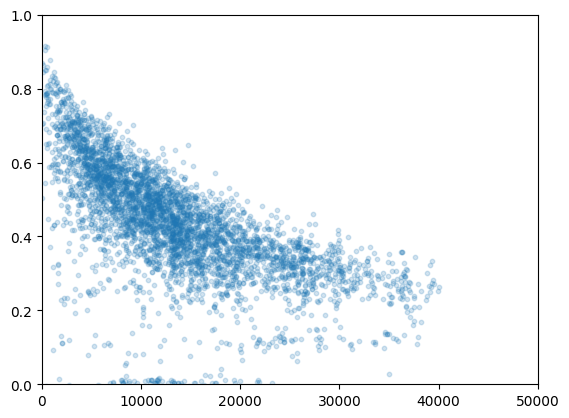

In [24]:
plt.scatter(dist_mtx, indcorr_mtx, alpha=0.2, s=10)
#plt.scatter(dist_mtx_ref, corr_mtx_ref, s=10)
plt.ylim(0, 1)
plt.xlim(0, 50e3);

In [13]:
ds_ref=xr.open_dataset("/home/IWS/seidel/RT_Pluviodata/10_netCDF_QC/Reutlingen_Pluviodata_2024_v2_1hourly_qc.nc")
ds_ref.load()
ds_ref.coords['x'], ds_ref.coords['y'] = plg.spatial.project_point_coordinates(
    ds_ref.longitude, ds_ref.latitude, target_projection="EPSG:25832",
)

In [14]:
ds_ref

<xarray.Dataset>
Dimensions:    (id: 12, time: 87049)
Coordinates:
  * id         (id) <U5 'RT_01' 'RT_02' 'RT_03' ... 'RT_10' 'RT_11' 'RT_12'
    latitude   (id) float64 48.55 48.53 48.53 48.51 ... 48.47 48.48 48.48 48.44
    longitude  (id) float64 9.216 9.194 9.228 9.194 ... 9.173 9.199 9.225 9.147
    elevation  (id) int64 300 344 337 418 372 334 383 377 392 379 397 518
  * time       (time) datetime64[ns] 2014-05-21 ... 2024-04-25
    x          (id) float64 5.159e+05 5.143e+05 ... 5.166e+05 5.109e+05
    y          (id) float64 5.378e+06 5.375e+06 5.376e+06 ... 5.37e+06 5.365e+06
Data variables:
    rainfall   (time, id) float64 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan nan
Attributes:
    title:         Pluvio data from Reutlingen
    institution:   IWS, University of Stuttgart
    history:       Test Version 0.1
    references:    N/A
    date_created:  2024-05-28 15:04:53
    conventions:   OPENSENSE V0
    location:      Reutlingen
    source:        SER Reutlingen
    comment:       naming convention OpenSense v0
    QC:            Two suspicious time slices for RT_06 (2019-11-15 - 2019-11...
    Resampled:     from 'Reutlingen_Pluviodata_2024_v2_qc.nc', unsing min 50 ...

In [25]:
dist_mtx_ref, corr_mtx_ref = pyqc.calc_indic_corr_all_stns(
    ds_ref.rainfall, 
    ds_ref.rainfall, 
    prob=0.99,
    min_valid_overlap=2*24*30,)

 36%|███▋      | 4/11 [00:00<00:00,  9.83it/s]

100%|██████████| 11/11 [00:00<00:00, 15.24it/s]


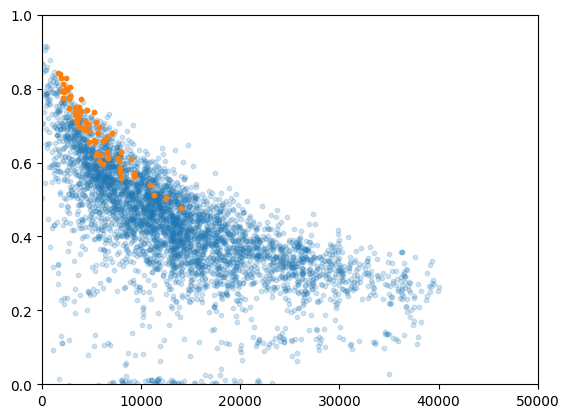

In [26]:
#plt.scatter(dist_vals, corr_vals, alpha=0.2, s=10)
plt.scatter(dist_mtx, indcorr_mtx, alpha=0.2, s=10)
plt.scatter(dist_mtx_ref, corr_mtx_ref, s=10)
plt.ylim(0, 1)
plt.xlim(0, 50e3);

In [18]:
dist_mtx_ref, indcorr_mtx_ref= pyqc.calc_indic_corr_all_stns(
    ds_ref.rainfall.shift(time=-1), 
    ds_pws.rainfall, 
    prob=0.99,
    min_valid_overlap=2*24*30,)

  0%|          | 0/11 [00:00<?, ?it/s]

100%|██████████| 11/11 [00:09<00:00,  1.10it/s]


In [19]:
dist_mtx_ref

<xarray.DataArray (id: 12, id_neighbor: 101)>
array([[24985.71395355, 18742.06179141, 17149.20612601, ...,
         1166.40626701,  1756.49827119,  1914.90864219],
       [24369.172     , 17644.07279082, 16743.9967057 , ...,
         2117.19387488,  3000.25682065,  3102.6831578 ],
       [22719.01931143, 16391.28884955, 14925.70461065, ...,
         2841.27229007,   911.14497176,   878.84430697],
       ...,
       [20485.47475082, 13227.87211447, 13538.58217324, ...,
         7560.84984622,  6927.0682228 ,  6893.25442391],
       [18846.0871941 , 11749.45124325, 11716.43079626, ...,
         7951.44253466,  6689.78399771,  6613.03779697],
       [21576.5357491 , 14094.97401759, 16376.72776513, ...,
        13472.21314109, 13372.78637631, 13359.07884698]])
Coordinates:
  * id           (id) <U5 'RT_01' 'RT_02' 'RT_03' ... 'RT_10' 'RT_11' 'RT_12'
  * id_neighbor  (id_neighbor) <U10 'RT_PWS_001' 'RT_PWS_002' ... 'RT_PWS_103'

In [23]:
indcorr_mtx_ref

<xarray.DataArray (id: 12, id_neighbor: 101)>
array([[       nan, 0.26124914,        nan, ..., 0.26799112, 0.24596982,
        0.2888288 ],
       [       nan,        nan,        nan, ..., 0.2903125 , 0.26058868,
        0.30416569],
       [       nan,        nan,        nan, ..., 0.2616895 , 0.23307687,
        0.28129347],
       ...,
       [       nan,        nan,        nan, ..., 0.263154  , 0.2482699 ,
        0.27498258],
       [       nan,        nan,        nan, ..., 0.2464955 , 0.26431434,
        0.27172721],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]])
Coordinates:
  * id           (id) <U5 'RT_01' 'RT_02' 'RT_03' ... 'RT_10' 'RT_11' 'RT_12'
  * id_neighbor  (id_neighbor) <U10 'RT_PWS_001' 'RT_PWS_002' ... 'RT_PWS_103'

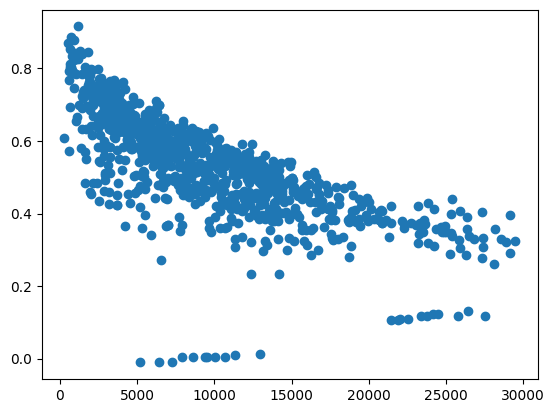

In [20]:
plt.scatter(dist_mtx_ref, indcorr_mtx_ref)

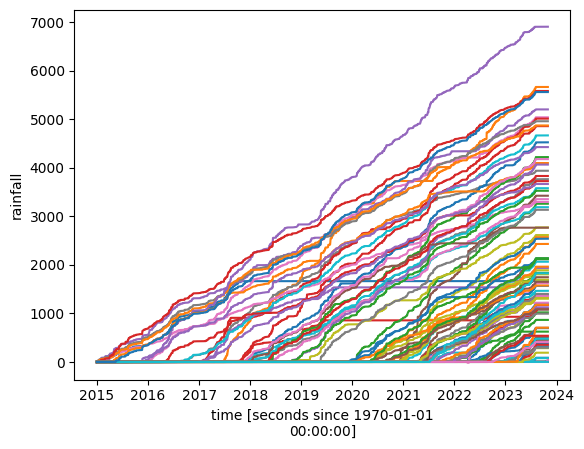

In [22]:
ds_pws.rainfall.cumsum(dim='time').plot.line(x='time', add_legend=False);

In [42]:
#End of the line weil 'calc_indicator_correlation' eine square matrix braucht!

<xarray.DataArray (id: 12, id_neighbor: 12)>
array([[    0.        ,  2812.33784361,  2357.38649124,  4734.56038809,
         4368.55442861,  6603.09747148,  5346.63769402,  9021.97424265,
         9343.08155085,  7881.08295158,  7992.55865435, 14057.70974092],
       [ 2812.33784361,     0.        ,  2575.71680226,  2182.50637845,
         3442.33299867,  3791.01063292,  3477.91710528,  6212.4547515 ,
         6686.57577306,  5518.56288382,  6138.71377284, 11359.1258605 ],
       [ 2357.38649124,  2575.71680226,     0.        ,  3401.22261457,
         2049.3243498 ,  5778.21287177,  3313.05262233,  7981.02816725,
         7783.09232167,  6018.32050597,  5802.37395216, 12480.68867236],
       [ 4734.56038809,  2182.50637845,  3401.22261457,     0.        ,
         2809.60980736,  2486.05687777,  1809.63872856,  4579.97917879,
         4608.57410532,  3339.83059831,  4166.16615392,  9326.04697039],
       [ 4368.55442861,  3442.33299867,  2049.3243498 ,  2809.60980736,
            0.        ,  5252.67498917,  1675.45280245,  7044.63573201,
         6341.74201707,  4343.47837526,  3806.18627851, 10908.77076031],
       [ 6603.09747148,  3791.01063292,  5778.21287177,  2486.05687777,
         5252.67498917,     0.        ,  3914.03322627,  2446.23388252,
         3563.11438   ,  3646.18322929,  5301.27284343,  7879.91786624],
       [ 5346.63769402,  3477.91710528,  3313.05262233,  1809.63872856,
         1675.45280245,  3914.03322627,     0.        ,  5446.77342481,
         4669.67684702,  2730.18870408,  2703.85914968,  9272.54528557],
       [ 9021.97424265,  6212.4547515 ,  7981.02816725,  4579.97917879,
         7044.63573201,  2446.23388252,  5446.77342481,     0.        ,
         2255.34731117,  3779.59721171,  5696.46684477,  5603.02586138],
       [ 9343.08155085,  6686.57577306,  7783.09232167,  4608.57410532,
         6341.74201707,  3563.11438   ,  4669.67684702,  2255.34731117,
            0.        ,  2168.38028874,  3915.94380365,  4723.44658589],
       [ 7881.08295158,  5518.56288382,  6018.32050597,  3339.83059831,
         4343.47837526,  3646.18322929,  2730.18870408,  3779.59721171,
         2168.38028874,     0.        ,  1917.14743069,  6566.1621585 ],
       [ 7992.55865435,  6138.71377284,  5802.37395216,  4166.16615392,
         3806.18627851,  5301.27284343,  2703.85914968,  5696.46684477,
         3915.94380365,  1917.14743069,     0.        ,  7715.57232337],
       [14057.70974092, 11359.1258605 , 12480.68867236,  9326.04697039,
        10908.77076031,  7879.91786624,  9272.54528557,  5603.02586138,
         4723.44658589,  6566.1621585 ,  7715.57232337,     0.        ]])
Coordinates:
  * id           (id) <U5 'RT_01' 'RT_02' 'RT_03' ... 'RT_10' 'RT_11' 'RT_12'
    id_neighbor  (id) <U5 'RT_01' 'RT_02' 'RT_03' ... 'RT_10' 'RT_11' 'RT_12'

In [19]:
distance_matrix = plg.spatial.calc_point_to_point_distances(
    ds_pws,
    ds_ref,
)

distance_matrix


<xarray.DataArray (id: 101, id_neighbor: 12)>
array([[24985.71395355, 24369.172     , 22719.01931143, ...,
        20485.47475082, 18846.0871941 , 21576.5357491 ],
       [18742.06179141, 17644.07279082, 16391.28884955, ...,
        13227.87211447, 11749.45124325, 14094.97401759],
       [17149.20612601, 16743.9967057 , 14925.70461065, ...,
        13538.58217324, 11716.43079626, 16376.72776513],
       ...,
       [ 1166.40626701,  2117.19387488,  2841.27229007, ...,
         7560.84984622,  7951.44253466, 13472.21314109],
       [ 1756.49827119,  3000.25682065,   911.14497176, ...,
         6927.0682228 ,  6689.78399771, 13372.78637631],
       [ 1914.90864219,  3102.6831578 ,   878.84430697, ...,
         6893.25442391,  6613.03779697, 13359.07884698]])
Coordinates:
  * id           (id) <U10 'RT_PWS_001' 'RT_PWS_002' ... 'RT_PWS_103'
  * id_neighbor  (id_neighbor) <U5 'RT_01' 'RT_02' 'RT_03' ... 'RT_11' 'RT_12'

In [42]:
tri2 = np.zeros((12, 12))
tri2[np.triu_indices(12, 1)] = corr_vals_ref


Function only for filtering based in the indicator correlations. Should take dist_vals and corr_vals (xr.DataArray) as input

In [26]:
import scipy
import tqdm

In [27]:
da_a=ds_ref
da_b=ds_ref

In [37]:
da_a.id

<xarray.DataArray 'id' (id: 12)>
array(['RT_01', 'RT_02', 'RT_03', 'RT_04', 'RT_05', 'RT_06', 'RT_07', 'RT_08',
       'RT_09', 'RT_10', 'RT_11', 'RT_12'], dtype='<U5')
Coordinates:
  * id         (id) <U5 'RT_01' 'RT_02' 'RT_03' ... 'RT_10' 'RT_11' 'RT_12'
    latitude   (id) float64 48.55 48.53 48.53 48.51 ... 48.47 48.48 48.48 48.44
    longitude  (id) float64 9.216 9.194 9.228 9.194 ... 9.173 9.199 9.225 9.147
    elevation  (id) int64 300 344 337 418 372 334 383 377 392 379 397 518
    x          (id) float64 5.159e+05 5.143e+05 ... 5.166e+05 5.109e+05
    y          (id) float64 5.378e+06 5.375e+06 5.376e+06 ... 5.37e+06 5.365e+06

In [106]:
max_distance=50000 # this is in meters, assuming the projection units are also meters
prob=0.99
exclude_nan=True 
min_valid_overlap=None

In [76]:
  for i in tqdm.tqdm(range(len(xy_a) - 1)):
    print(i)
    for j in range(i + 1, len(xy_b)):
            # check if distance between stations is less than max_distance
            if dist_mtx[i, j] < max_distance:
              print(i,j)
              indcorr_mtx[i,j]  = calc_indicator_correlation(
                    da_a.isel(id=i).rainfall.data, 
                    da_b.isel(id=j).rainfall.data,
                    prob=prob,
                    exclude_nan=exclude_nan, 
                    min_valid_overlap=min_valid_overlap,
                )
                #list_dist.append(dist_mtx[i, j])
                #list_corr.append(indi_corr)

  0%|          | 0/11 [00:00<?, ?it/s]

0
0 1


TypeError: int() argument must be a string, a bytes-like object or a real number, not 'tuple'

In [86]:
a=da_a.isel(id=i).rainfall.data
b=da_b.isel(id=j).rainfall.data

In [100]:
    a_dataset = np.copy(a)
    b_dataset = np.copy(b)

In [101]:
both_not_nan = ~np.isnan(a_dataset) & ~np.isnan(b_dataset)
a_dataset = a_dataset[both_not_nan]
b_dataset = b_dataset[both_not_nan]


In [109]:
ix=int((a_dataset.shape[0])*prob)

In [102]:
 ix = int(a_dataset.shape[0] * prob)

TypeError: int() argument must be a string, a bytes-like object or a real number, not 'tuple'

In [98]:
np.nan(a)

TypeError: 'float' object is not callable

In [77]:
indcorr_mtx[i,j] = 1

In [87]:
pyqc.calc_indicator_correlation(
    a, 
    b,
    prob=prob,
    exclude_nan=exclude_nan, 
    min_valid_overlap=min_valid_overlap)

TypeError: int() argument must be a string, a bytes-like object or a real number, not 'tuple'

In [17]:
hupsi= dist_vals=xr.DataArray(dist_vals, data={'id' : da_a.id , 'id_neighbor' : da_b.id })

ValueError: different number of dimensions on data and dims: 1 vs 2

In [21]:
import scipy

In [18]:
ds = xr.open_dataset('/home/IWS/seidel/PWS_data/EGLV_nc/EGLV_PWS_1h_v3.nc')

In [23]:
N = 50000
a = np.random.randn(N, 2)
b = np.random.randn(N, 2)

In [24]:
cdist = scipy.spatial.distance.cdist(a, b)
distance_matrix = scipy.spatial.distance_matrix(a, b)

In [28]:
plg.spatial.calc_point_to_point_distances(ds,ds)

<xarray.DataArray (id: 3603, id_neighbor: 3603)>
array([[     0.        ,   1884.24939434,   1134.5539469 , ...,
        133851.13493181, 151994.72619322, 169402.15211633],
       [  1884.24939434,      0.        ,    750.62308115, ...,
        135077.93300577, 153076.76494743, 170476.0447403 ],
       [  1134.5539469 ,    750.62308115,      0.        , ...,
        134565.81149638, 152620.49001574, 170023.10206811],
       ...,
       [133851.13493181, 135077.93300577, 134565.81149638, ...,
             0.        ,  22817.90386293,  38713.50067235],
       [151994.72619322, 153076.76494743, 152620.49001574, ...,
         22817.90386293,      0.        ,  17424.23250807],
       [169402.15211633, 170476.0447403 , 170023.10206811, ...,
         38713.50067235,  17424.23250807,      0.        ]])
Coordinates:
  * id           (id) <U13 'EGLV_PWS_0001' 'EGLV_PWS_0002' ... 'EGLV_PWS_3603'
  * id_neighbor  (id_neighbor) <U13 'EGLV_PWS_0001' ... 'EGLV_PWS_3603'

In [30]:
plg.spatial.get_closest_points_to_point(ds,ds,max_distance=50000,n_closest=1000)

<xarray.Dataset>
Dimensions:      (id: 3603, n_closest: 1000)
Coordinates:
  * id           (id) <U13 'EGLV_PWS_0001' 'EGLV_PWS_0002' ... 'EGLV_PWS_3603'
Dimensions without coordinates: n_closest
Data variables:
    distance     (id, n_closest) float64 0.0 331.2 1.135e+03 ... inf inf inf
    neighbor_id  (id, n_closest) object 'EGLV_PWS_0001' 'EGLV_PWS_3064' ... None